In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as init

  Created wheel for yfinance: filename=yfinance-0.1.50-py2.py3-none-any.whl size=21556 sha256=499052ce4856bfe96f8595060e6ef6ee70da91c912717fc08c5895766befefc9
  Stored in directory: /root/.cache/pip/wheels/19/2a/e6/b4d4cc977576e18220a36866acf2f2cf7241f16af5f8795b17
Successfully built yfinance


In [2]:
price = yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


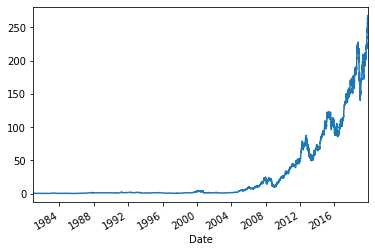

In [3]:
price['Adj Close'].plot()

In [0]:
class MTimeSLoader():
    def __init__(self, price,batch_size,seq_len):
        self.price = price
        self.batch_size = batch_size
        self.seq_len = seq_len

    def RSICalc(self,price):
        delta = price['Adj Close'].diff()
        dUp, dDown = delta.copy(), delta.copy()
        dUp[dUp < 0] = 0
        dDown[dDown > 0] = 0
        RolUp = dUp.rolling(window=14).mean()
        RolDown = dDown.abs().rolling(window=14).mean()
        return np.where(RolDown != 0,RolUp / RolDown,1)

    def getTI(self,price):
        adjustment = price['Adj Close']/price['Close']

        # VOLITILIY
        # Bollinger Bands
        std_20 = price['Adj Close'].rolling(window=20).std() 
        ub = price['Adj Close'] - 2 * std_20
        lb = price['Adj Close'] + 2 * std_20

        # TREND
        # Moving Averages
        ma_10 = price['Adj Close'].rolling(window=10).mean()
        ma_20 = price['Adj Close'].rolling(window=20).mean()

        # Moving Averae Convergence Divergence
        ema_26 = pd.Series.ewm(price['Adj Close'],span=26).mean()
        ema_12 = pd.Series.ewm(price['Adj Close'],span=12).mean()
        macd = ema_26-ema_12

        # MOMENTUM 
        # RSI 
        rsi = self.RSICalc(price)
        return pd.DataFrame({'ma_10':ma_10,'ma_20':ma_20,'macd':macd,'bol_lb':lb,'bol_up':ub, 'rsi':rsi})

    def getFI(self,price):
        return pd.DataFrame({})

    def getFFTComponents(self,price):
        close_fft = np.fft.fft(np.asarray(price['Adj Close'].tolist()))
        fft_df = pd.DataFrame({'fft':close_fft})
        real = fft_df['fft'].apply(lambda x: np.abs(x))
        angle = fft_df['fft'].apply(lambda x: np.angle(x))
        df =  pd.DataFrame(data = {'real':real,'angle':angle})
        df.index = price.index
        return df

    def getFeatures(self,price):
        return pd.concat([price['Adj Close'].pct_change(),]) # self.getTI(price), self.getFI(price), self.getFFTComponents(price)],axis=1)

    def __len__(self):
        return len(self.prices.shape[0])

    def get(self):
        data = self.getFeatures(self.price)[30:]
        filt = data.to_numpy()[self.seq_len:]
        items = filt.shape[0]
        choice = np.random.choice(items, self.batch_size, replace=False)
        return np.vstack([np.vstack([filt[r] for r in range(i-self.seq_len,i)]).reshape(self.seq_len,-1) for i in choice]).reshape(self.batch_size,self.seq_len,-1)


In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


def get_distribution_sampler(price,window_size):
    return MTimeSLoader(price,1,window_size).get()

def get_generator_input_sampler(nz):
    return torch.randn(1,nz)

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f
    
    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f
        self.dropout = nn.Dropout(p=0.5)
        self.soft = nn.Softmax()

    def forward(self, x):
        x = self.map1(x)
        x = self.dropout(self.f(x))
        x = self.map2(x)
        x = self.dropout(self.f(x))
        x = self.map3(x)
        return self.soft(x)

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def train(price,window_size):
    # Model parameters
    g_input_size = 50      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 100     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 1    # Minibatch size - cardinality of distributions
    d_hidden_size = 100    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 0.0004
    g_learning_rate = 0.0001
    sgd_momentum = 0.9

    num_epochs = 1000
    print_interval = 50
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function).float()
    D = Discriminator(input_size=d_input_size,
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function).float()
    criterion = nn.BCELoss()

    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            D.zero_grad()
            d_real_data = torch.from_numpy(get_distribution_sampler(price,window_size)).view(1,window_size).float()
            d_real_decision = D(d_real_data)
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1]))) 
            d_real_error.backward() 

            d_gen_input = get_generator_input_sampler(g_input_size).view(1,g_input_size)
            d_fake_data = G(d_gen_input).detach()
            d_fake_decision = D(d_fake_data)
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1]))) 
            d_fake_error.backward()
            d_optimizer.step()    

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            gen_input = get_generator_input_sampler(g_input_size).view(1,g_input_size)
            g_fake_data = G(gen_input)
            dg_fake_decision = D(g_fake_data)
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))
            g_error.backward()
            g_optimizer.step() 
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    return G

G = train(price,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([0.06679727137088776, 0.0]),  Fake Dist ([0.15368497371673584, 0.0]) 
Epoch 50: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([-0.04225323721766472, 0.0]),  Fake Dist ([0.218950092792511, 0.0]) 
Epoch 100: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([0.026819461956620216, 0.0]),  Fake Dist ([0.10215651988983154, 0.0]) 
Epoch 150: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([0.004524679854512215, 0.0]),  Fake Dist ([0.1867516040802002, 0.0]) 
Epoch 200: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([-0.012258397415280342, 0.0]),  Fake Dist ([0.25401201844215393, 0.0]) 
Epoch 250: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([0.015037230215966702, 0.0]),  Fake Dist ([0.024647502228617668, 0.0]) 
Epoch 300: D (0.0 real_err, 27.63102149963379 fake_err) G (0.0 err); Real Dist ([-0.000460806593764

In [0]:
latent = torch.randn(10000, 50).cuda()
dat = G(latent)
dat = dat.view(10000,-1)

In [0]:
rets = []
for i in range(10000):
  rets.append(dat[i][-1].item())

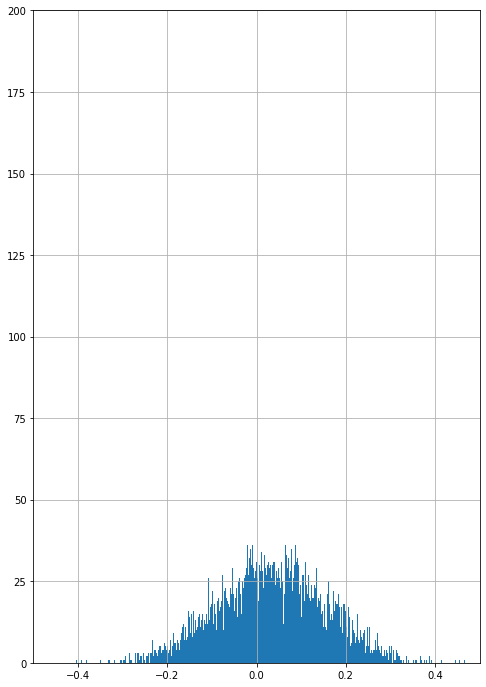

In [27]:
gen_ret = pd.Series(rets)
fig = plt.figure(figsize = (8,12))
ax = fig.gca()
ax.set_ylim(0,200)
ax.set_xlim(-0.5,0.5)
gen_ret.hist(bins=1000,ax=ax)

In [0]:
gen_ret.quantile(0.01)